In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
load('/import/mdd.rna/GSE80655.rda')

In [3]:
load('./bulk.fpkm.fpkm.rda')

In [4]:
ls()

[1] "cliinfo" "expr3"   "fpkm"

In [5]:
fpkm = fpkm^2-1

In [6]:
library(dplyr)
cliinfo = cliinfo %>%  filter(V4 == 'M') %>%  select(V1,V3)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [7]:
con = cliinfo %>%   filter(V3 =='Control')

In [8]:
load('testset1.groups.rda')

In [9]:
colnames(ano) = c('V1','V3')

In [10]:
cliinfo = rbind(ano,con)

In [11]:
head(cliinfo)

,V1,V3
,<chr>,<chr>
1,SL32231,subtype1
2,SL32245,subtype1
3,SL32247,subtype1
4,SL32248,subtype1
5,SL5997,subtype1
6,SL5998,subtype2


In [12]:
table(cliinfo$V3)


 Control subtype1 subtype2 
      21        6       11 

In [13]:
group = data.frame(sample = cliinfo$V1,
                  group = cliinfo$V3)

In [14]:
rownames(group) = group[,1]

In [15]:
library(dplyr)

In [16]:
group = group %>%tibble::remove_rownames() %>%   tibble::column_to_rownames(.,'sample')

In [17]:
group.all1 = group

In [18]:
fpkm = fpkm[,rownames(group)]

In [19]:
dataExpr = fpkm

In [20]:
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
#exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

Warning message:
"package 'WGCNA' was built under R version 4.2.3"
Loading required package: dynamicTreeCut

Warning message:
"package 'dynamicTreeCut' was built under R version 4.2.3"
Loading required package: fastcluster

Warning message:
"package 'fastcluster' was built under R version 4.2.3"

Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor


Warning message:
"package 'reshape2' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"


Allowing parallel execution with up to 255 working processes.


In [21]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.25))[2],0.01)),]

dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [22]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}


In [23]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]    38 13194

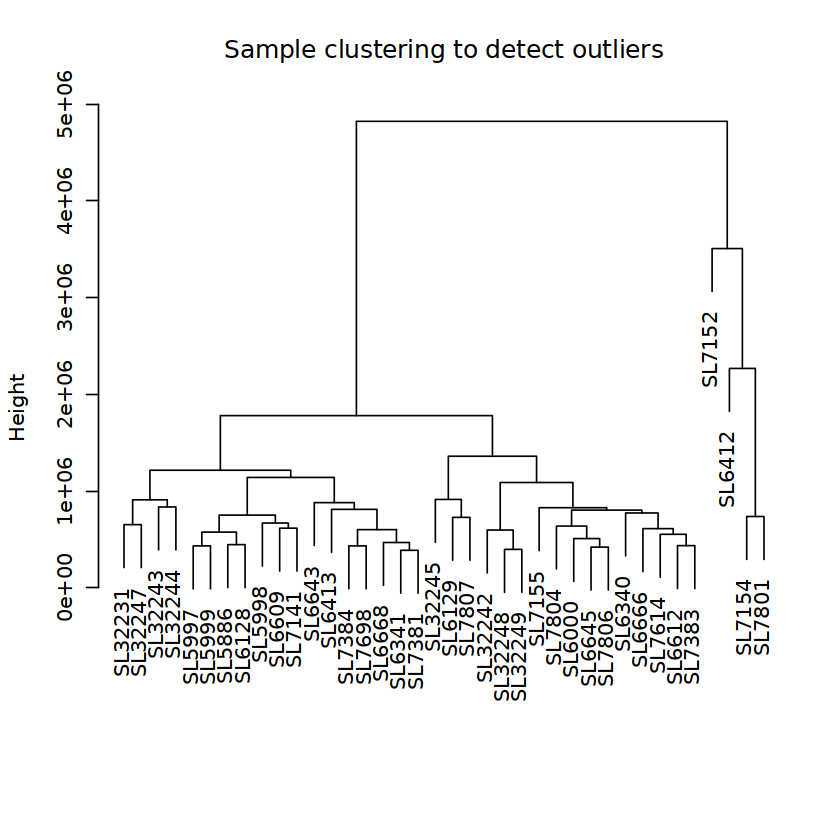

In [24]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [25]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 3390.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3390 of 13194
   ..working on genes 3391 through 6780 of 13194
   ..working on genes 6781 through 10170 of 13194
   ..working on genes 10171 through 13194 of 13194
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.674  2.660          0.917 3520.00  3650.000   4910
2      2    0.291  0.545          0.854 1450.00  1450.000   2610
3      3    0.234 -0.382          0.939  736.00   687.000   1760
4      4    0.674 -0.865          0.985  427.00   363.000   1340
5      5    0.826 -1.140          0.964  271.00   209.000   1080
6      6    0.891 -1.290          0.947  184.00   127.000    909
7      7    0.924 -1.370          0.941  131.00    80.300    782
8      8    0.940 -1.410          0.940   97.40    52.200    684
9      9    0.952 -1.420          0.944   74.70    35.300    606
10    10    0.956 -1.410          0.945   58

In [26]:
options(repr.plot.width = 9)

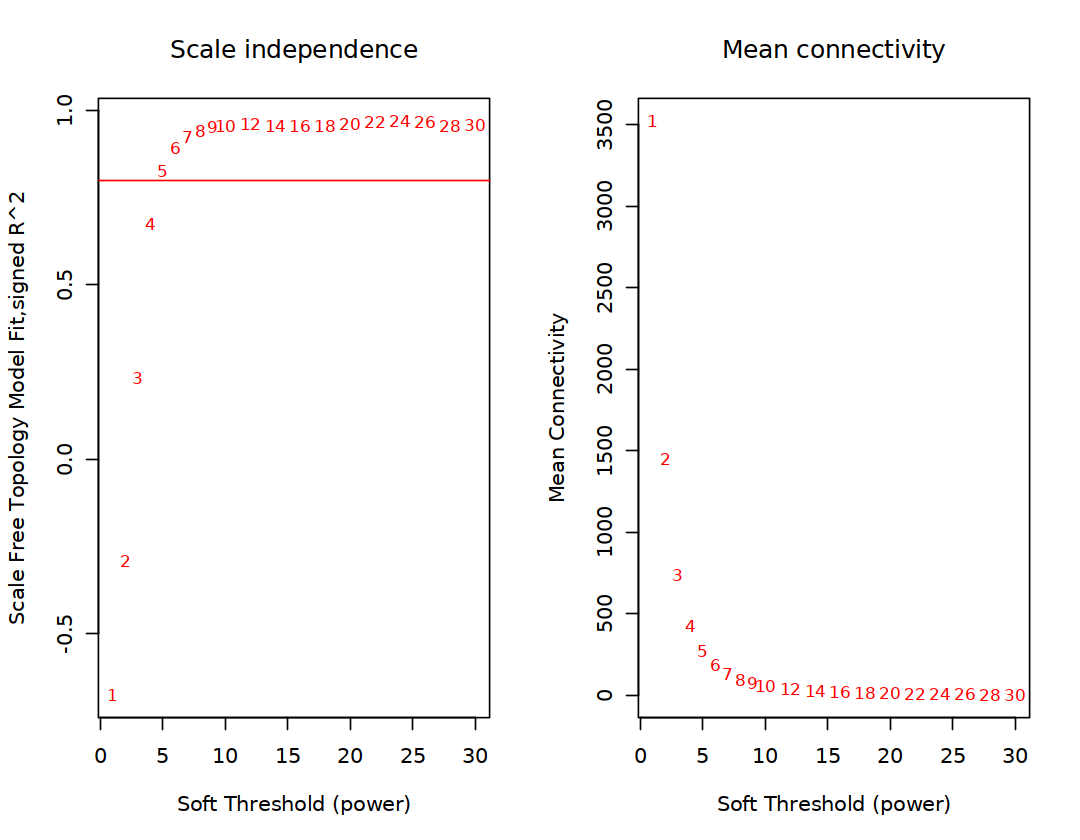

In [27]:
par(mfrow = c(1,2))
cex1 = 0.8
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.8,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [28]:
power = sft$powerEstimate
power

[1] 6

In [29]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [30]:
exprMat='data.txt'

In [31]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 50,
                       reassignThreshold = 0, mergeCutHeight = 0.45,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file data.txt.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 86 genes from module 1 because their KME is too low.
     ..removing 42 genes from module 2 because their KME is too low.
     ..removing 12 genes from module 3 because their KME is too low.
     ..removing 3 genes from module 4 because their KME is too low.
     ..removing 29 genes from module 5 because their KME is too low.
     ..removing 16 genes from module 6 because their KME is too low.
     ..removing 14 genes from module 7 be

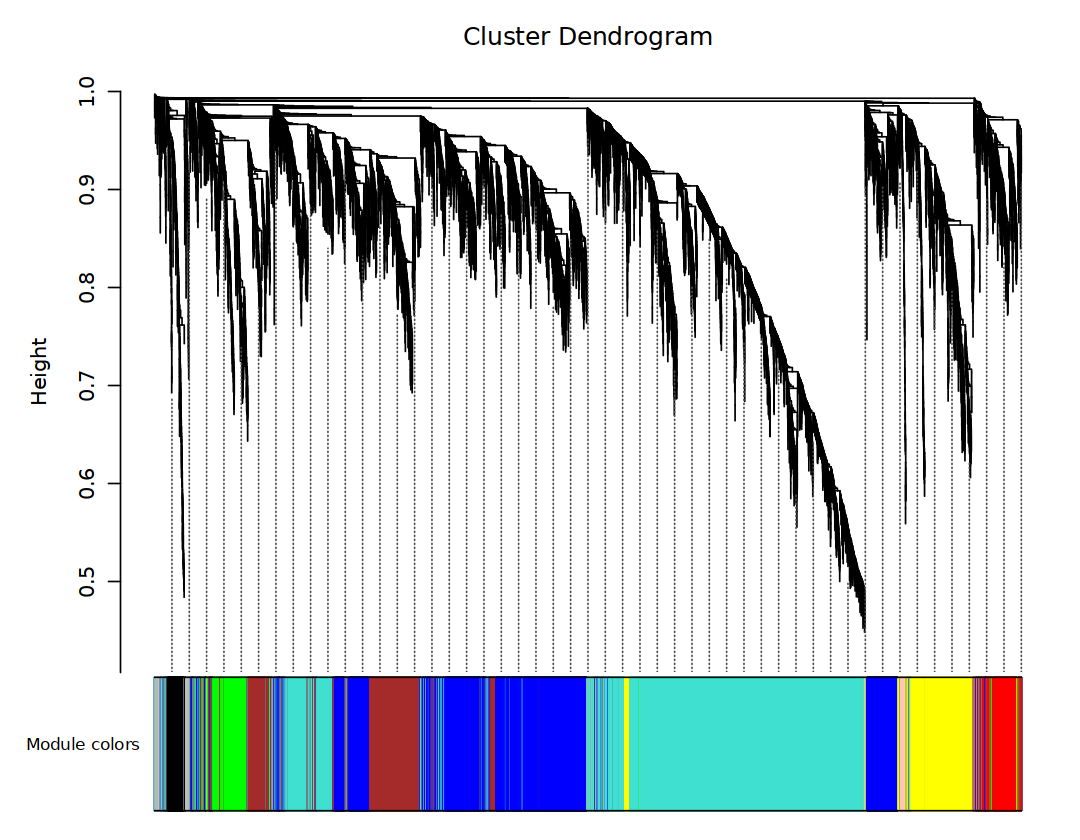

In [32]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [33]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

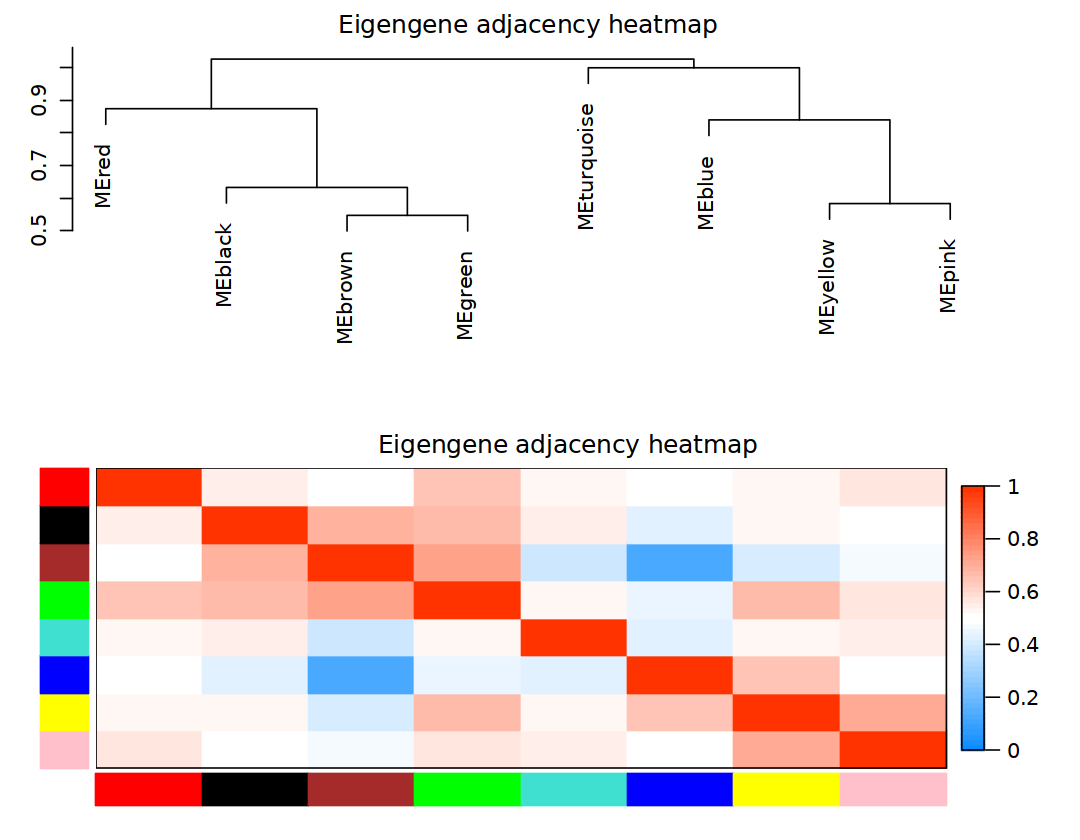

In [34]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [35]:
TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

TOM calculation: adjacency..
..will use 128 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [36]:
group.all1 = group

In [37]:
group.all1  = group.all1 %>%  tibble::rownames_to_column(.,'sample')

In [38]:
group.all1$group = as.character(group.all1$group )

In [39]:
design <- model.matrix(~0 + group.all1$group)


In [40]:
dimnames(design) <- list(group.all1$sample, sort(unique(group.all1$group)))


In [41]:
design <- design[rownames(MEs_col),]

In [42]:
# 计算 pearson 相关性和显著性
modTraitCor <- cor(MEs_col, design, use = "p")
modTraitP <- corPvalueStudent(modTraitCor, dim(group.all1)[1])

In [43]:
modTraitCorP = bicorAndPvalue(MEs_col, design)
modTraitCor = modTraitCorP$bicor
modTraitP   = modTraitCorP$p

Warning message in bicor(x, y, use = use, ...):
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


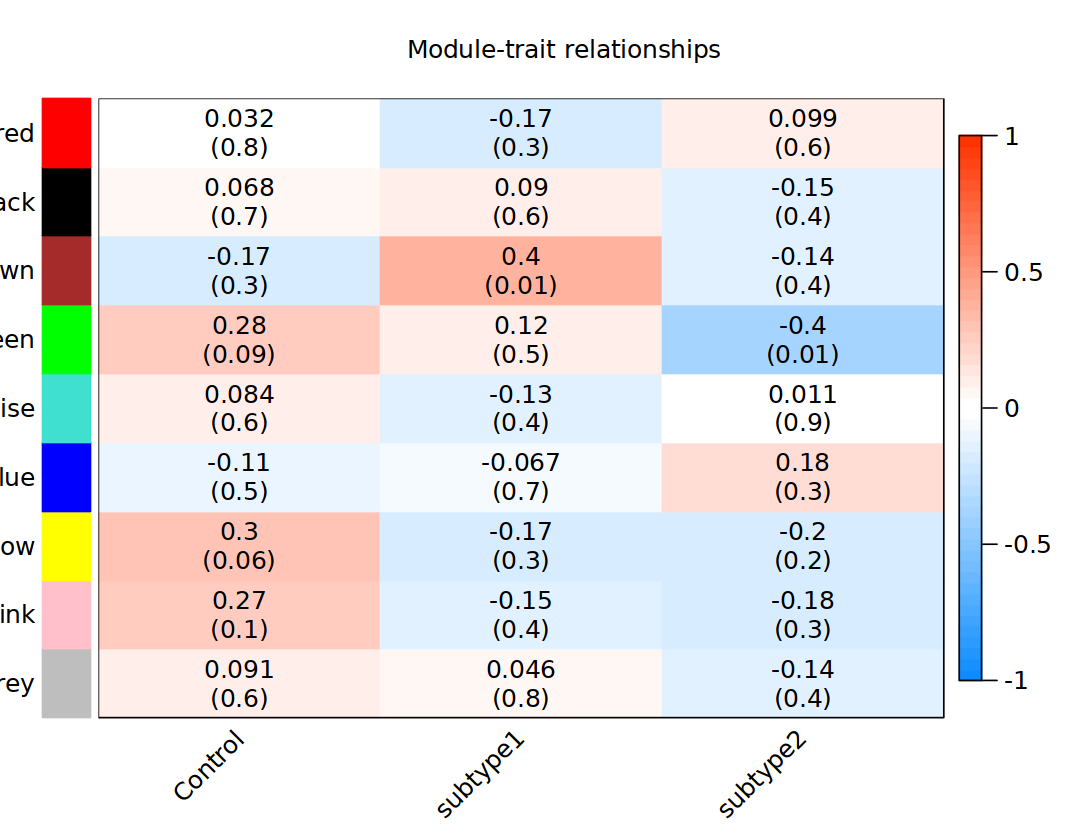

In [46]:
textMatrix <- paste0(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")")
dim(textMatrix) <- dim(modTraitCor)
labeledHeatmap(
  Matrix = modTraitCor,
  xLabels = colnames(design),
  yLabels = colnames(MEs_col),
  cex.lab = 1.2,
  ySymbols = colnames(MEs_col),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = FALSE,
  cex.text = 1.2,
  zlim = c(-1, 1),
  main = paste("Module-trait relationships")
)

In [37]:
dat = dataExpr

In [48]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, design, use = "p")) 

In [49]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(design), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(design), sep="")

In [50]:
module <- "yellow"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

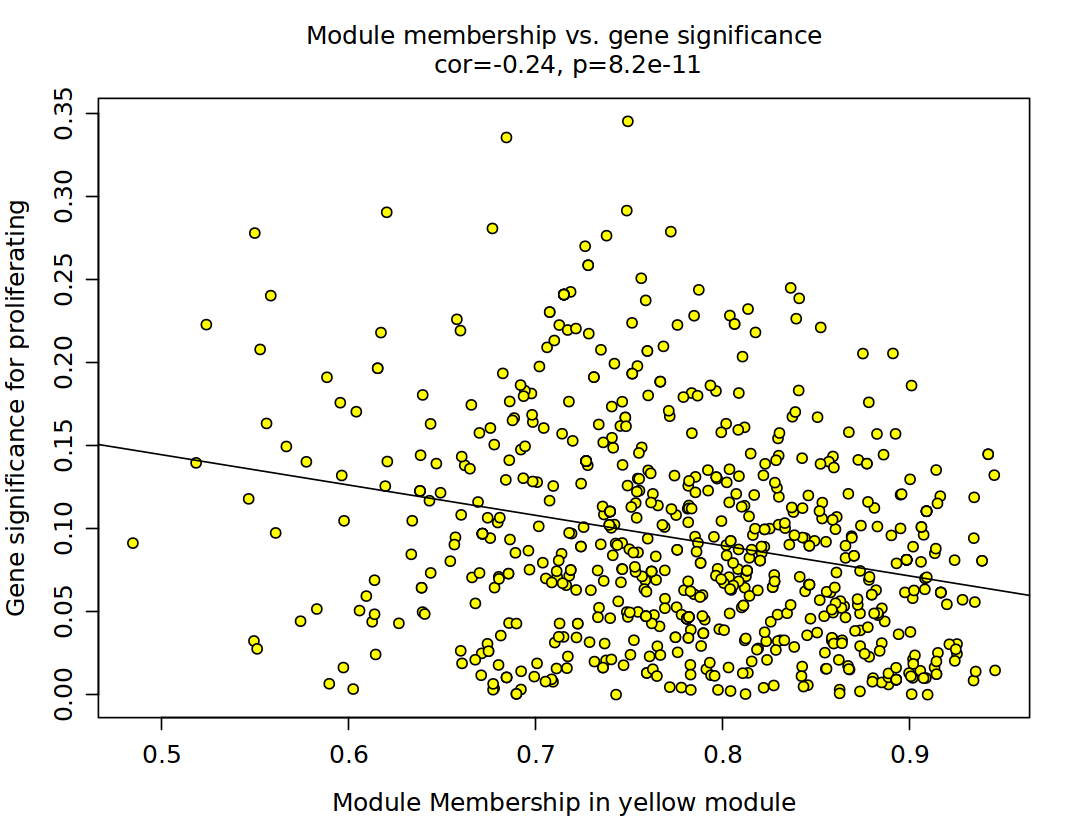

In [51]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

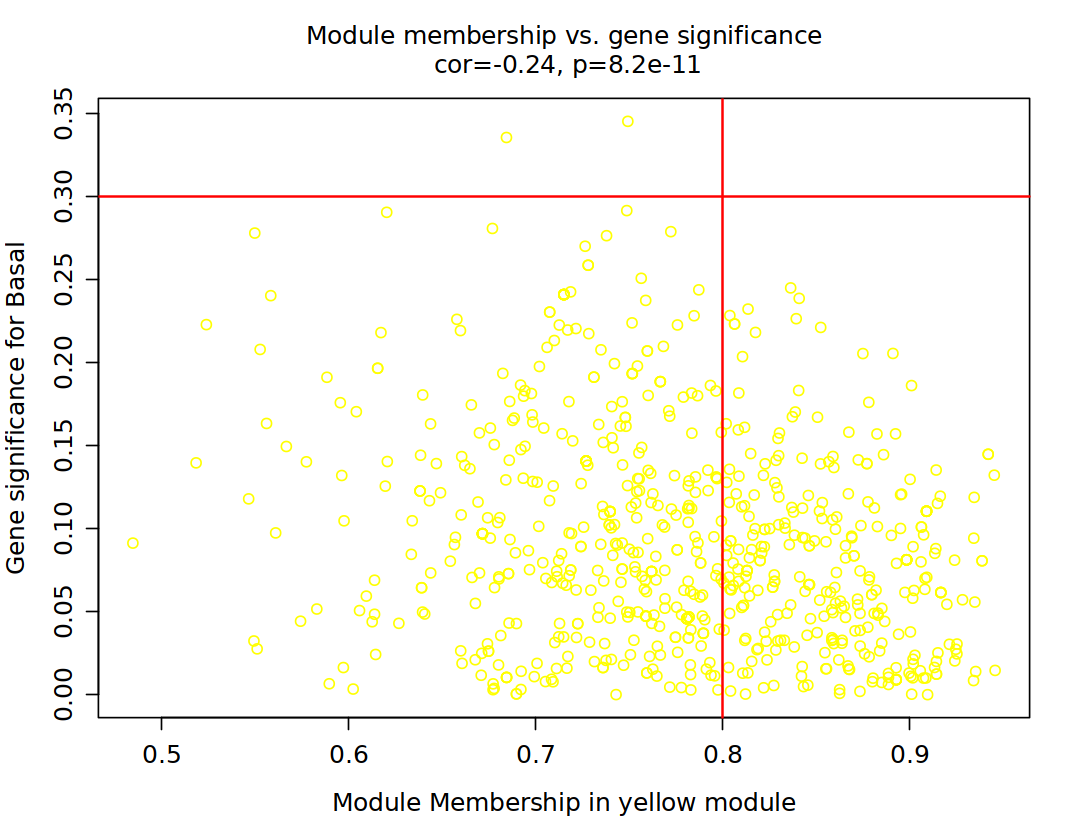

In [52]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

In [53]:
brown_hub <- brown_moduleGenes[(GS > 0.3 & MM > 0.8)]
length(brown_hub)

[1] 0

In [54]:
write.csv(brown_hub,'brown_hub_gene.csv')

In [55]:
library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('brown_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")


Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfil

ERROR: Error in mapIds_base(x, keys, column, keytype, ..., multiVals = multiVals): mapIds must have at least one key to match against.


In [ ]:
table(is.na(sig_DP_entrezId))

In [ ]:

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "ALL",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)


In [ ]:
#画图
dotplot(go_bp)

In [ ]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
    #ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   